# Lesson1, Lesson2

- [Lesson1](http://course.fast.ai/lessons/lesson1.html)
- [Lesson2](http://course.fast.ai/lessons/lesson2.html)
- [data](http://files.fast.ai/)
- [Git](https://github.com/fastai/courses/tree/master/deeplearning1)
- [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
- [Training a classifier](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [Deep Learning Building Blocks: Affine maps, non-linearities and objectives ~Softmax and Probabilities~](http://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#softmax-and-probabilities)
- [Autograd mechanics](http://pytorch.org/docs/master/notes/autograd.html)
- Pytorch Forum
  - [How to modify the final FC layer based on the torch.model](https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766)
  - [How to perform finetuning in Pytorch?](https://discuss.pytorch.org/t/how-to-perform-finetuning-in-pytorch/419)
  - [Given vgg16, how to remove pool5 layer and all the classify layers?](https://discuss.pytorch.org/t/given-vgg16-how-to-remove-pool5-layer-and-all-the-classify-layers-and-how-to-add-new-layers-to-that-while-keeping-the-pretrained-weights/1653)

In [1]:
%matplotlib inline

In [2]:
!wget http://files.fast.ai/data/dogscats.zip

--2018-10-20 12:46:37--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: 'dogscats.zip'

dogscats.zip        100%[===================>] 817.50M  8.96MB/s    in 98s     

2018-10-20 12:48:15 (8.36 MB/s) - 'dogscats.zip' saved [857214334/857214334]



In [ ]:
!unzip dogscats.zip

In [4]:
!mkdir data

In [5]:
!mv dogscats data

In [6]:
path = "data/dogscats/sample/"

In [1]:
import time
import os

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets

## Pretrained modelの試行

http://pytorch.org/docs/master/torchvision/models.html に書いてあるように、pretrainedモデルに合わせてCropとNormalizeが必要

また、ImageFolderは以下のようなデータを想定

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

In [8]:
# http://pytorch.org/docs/master/torchvision/transforms.html
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224), # 画像のサイズを合わせ、その値はpretrainedモデルに合わせる
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # PIL.ImageをTensorに
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
batch_size=12
dataset = datasets.ImageFolder(root=path+"train", transform=data_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
class_names = dataset.classes # 自動的にディレクトリ名からclass名のリストを作成
print(class_names)

['cats', 'dogs']


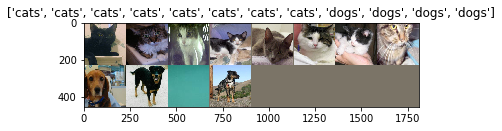

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # 正規化をもとに戻す    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
# batchを結合したFloadTensorが戻り値
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.torch/models/vgg16-397923af.pth
100.0%


In [12]:
for i, data in enumerate(train_loader, 0):
    images, labels = data
    outputs = vgg16(images)
    # get the index of the highest energy
    # (最大値のTensor, 最大値のindexのTensor) のタプルが戻り値
    _, predicted = torch.max(outputs.data, dim=1)
    print(predicted) # 1000分類される

tensor([285, 281, 356, 250, 282, 285, 359, 281, 162, 234, 151, 227])
tensor([256, 244, 244, 179])


## Pretrained モデルの出力をlinear層に掛けて学習

1. trainとvalidそれぞれで、vgg16で推論
2. そのデータを保存
3. Datasetを定義して、featuresとlabelsをDataloaderから得られるようにする
4. linearモデルを作成し、学習

### 手順1

In [2]:
vgg16 = models.vgg16(pretrained=True)

In [6]:
# どちらも正規化のみにする
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # 本当に中央をクロッピングするだけなのでResizeが必要
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
path = "data/dogscats/"
batch_size = 32 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transform)
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4) # 後で結果を使うのでShuffleはfalse
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'train': 23000, 'valid': 2000} ['cats', 'dogs']


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')
device

device(type='cuda', index=0)

In [9]:
result_map = {'train': [], 'valid': []}
vgg16.train(False)
vgg16 = vgg16.to(device)
for phase in ['train', 'valid']:   
    for data in dataloaders[phase]:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = vgg16(inputs)
        result_map[phase].append(outputs.detach().to(cpu_device))

### 手順2

In [10]:
feature_tensors = {x: torch.cat(result_map[x]) for x in ["train", "valid"]}

In [11]:
for x in ["train", "valid"]:
    torch.save(feature_tensors[x], f"pretrain_features_{x}.pt")

### 手順3

In [19]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, image_folder, features):
        self.image_folder = image_folder
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        _, label = self.image_folder.__getitem__(idx)
        return self.features[idx], label

In [20]:
feature_tensors = {}
for x in ["train", "valid"]:
    feature_tensors[x] = torch.load(f"pretrain_features_{x}.pt")

In [28]:
batch_size = 12
path = "data/dogscats/"
# どちらも正規化のみにする
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# precomputeして特徴量を得ているので、ここでもdata augmentationをしないdata_transformを用いる
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transform) for x in ['train', 'valid']}
linear_datasets = {x: LinearDataset(image_datasets[x], feature_tensors[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(linear_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(linear_datasets[x]) for x in ['train', 'valid']}
class_names = linear_datasets['train'].image_folder.classes
print(dataset_sizes, class_names)

{'train': 23000, 'valid': 2000} ['cats', 'dogs']


### 手順4

In [29]:
fc = nn.Linear(1000, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.detach(), 1) # CrossEntropyLossにsoftmaxも含まれているので、Lossのprint時は自分でmaxを算出
                loss = criterion(outputs, labels) # 0 <= labels[i] <= C-1 となっている

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() # loss.dataはsize 1 のTensorなのでitem()でPython numberを取得
                running_corrects += torch.sum(preds == labels.detach()).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [39]:
model_linear = train_model(fc, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0145 Acc: 0.9970
valid Loss: 0.9095 Acc: 0.8700

Epoch 1/4
----------
train Loss: 0.0180 Acc: 0.9957
valid Loss: 0.4280 Acc: 0.9200

Epoch 2/4
----------
train Loss: 0.0519 Acc: 0.9817
valid Loss: 0.0999 Acc: 0.9680

Epoch 3/4
----------
train Loss: 0.0268 Acc: 0.9870
valid Loss: 0.0898 Acc: 0.9690

Epoch 4/4
----------
train Loss: 0.0234 Acc: 0.9879
valid Loss: 0.0815 Acc: 0.9695

Training complete in 4m 48s
Best val Acc: 0.969500


## Finetune

[Transfer Learning Tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

- pretrained modelの最後の層だけ置き換えて学習する
- どの層から変更するからは試してみるしかないらしい (最後が一般的)

In [2]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

path = "data/dogscats/"
batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'train': 23000, 'valid': 2000} ['cats', 'dogs']


In [4]:
# 置き換える層以外は再学習しないようにする
for param in vgg16.parameters():
    param.requires_grad = False

In [5]:
num_features = vgg16.classifier[6].in_features
modules = list(vgg16.classifier.children())
modules.pop()
modules.append(torch.nn.Linear(num_features, len(class_names)))
new_classifier = torch.nn.Sequential(*modules)
vgg16.classifier = new_classifier

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9) # requires_grad=Falseのパラメーターを渡したらエラーが出た
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')
device

device(type='cuda', index=0)

In [11]:
model_finetuned = train_model(vgg16, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0038 Acc: 0.9497
valid Loss: 0.0010 Acc: 0.9900

Training complete in 5m 55s
Best val Acc: 0.990000


In [12]:
torch.save(model_finetuned.state_dict(), "lesson1_finetuned.pt")

## Kaggle提出

提出フォーマット

```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

[Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

を参考に、testデータ用のloaderを作成する

In [13]:
vgg16 = models.vgg16(pretrained=False)
num_features = vgg16.classifier[6].in_features
modules = list(vgg16.classifier.children())
modules.pop()
modules.append(torch.nn.Linear(num_features, 2))
new_classifier = torch.nn.Sequential(*modules)
vgg16.classifier = new_classifier
vgg16.load_state_dict(torch.load("lesson1_finetuned.pt"))
model_finetuned = vgg16

In [14]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class KaggleDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.transform = transform

    def __len__(self):
        return 12500 # ひとまず固定値(本当はディレクトリのファイル数を取れば良い)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, "{0}.jpg".format(idx+1))
        image = Image.open(img_name) # ImageFolderと合わせてPIL.Image形式で読み込み
        if self.transform:
            image = self.transform(image)

        return image

In [17]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
batch_size=32
path = "data/dogscats/"
dataset = KaggleDataset(root=path+"test1", transform=data_transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

- PytorchのCrossEntropyLossにはsoftmax算出部分も含まれている
- 普段推論する分には、maxを取ればよいのでsoftmaxは不要
- 今回のように確率値にしたいときはsoftmaxが必要

In [18]:
import torch.nn.functional as F
model_finetuned.train(False)
results = []
model_finetuned.to(device)
for data in test_loader:
    inputs = data.to(device)
    outputs = F.softmax(model_finetuned(inputs), dim=1)
    results.append(outputs.detach().to(cpu_device))

result_tensor = torch.cat(results)
torch.save(result_tensor, "lesson1_result.pt")
np.savetxt("kaggle_output", result_tensor.numpy()[:,0])

In [23]:
result_tensor[0]

tensor([0.0018, 0.9982])

In [24]:
output_data = np.dstack((np.asarray(range(1, 12501)), result_tensor.numpy()[:,1]))
np.savetxt("kaggle_output", output_data[0], delimiter=",", fmt=["%d", "%.10e"])

In [25]:
output_data[0]

array([[1.0000e+00, 9.9815e-01],
       [2.0000e+00, 1.0000e+00],
       [3.0000e+00, 9.9934e-01],
       ...,
       [1.2498e+04, 9.9956e-01],
       [1.2499e+04, 9.9996e-01],
       [1.2500e+04, 2.1049e-07]])